In [1]:
import collections
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.contrib import seq2seq
import time

In [2]:
poetry_file ='poetry.txt'

## Data Preprocessing

In [3]:
import re
import string
from collections import Counter

In [4]:
class readPoems:
    '''
    Read Chinese poems and generate poem vectors for training
    Args:
    file_path:file path of Chinese poems
    '''
    def __init__(self, file_path):
        self.file_path = file_path
        self.poems = self._readfile()
        self.poems_chars, self.all_chars = self._poem2chars()
    
    
    def _preProcessor(self, s):
        #remove letters
        s = re.sub('[a-zA-Z一《》]', '', s)
        #remove blanks
        s = re.sub(' ', '', s)
        #remove digits
        s = re.sub('['+string.digits+']', '', s)
        #remove line ends
        s = re.sub('\n', ' ', s)
        s = s.rstrip()
        return s
    
    def _readfile(self):
        poems = []
        with open(self.file_path, "r", encoding='utf-8',) as fi:
            for line in fi:
                content = line.strip().split(':')[1]
                if len(content) > 10:#skip short sentences
                    poem = self._preProcessor(content)
                    #Set beginning and ending for each poem
                    poem ='(' + poem +')'
                    poems.append(poem)
                    
        #Sort the poems according to their lengths
        poems_lens = [len(poem) for poem in poems]
        poem_tuple = list(zip(poems_lens, poems))
        poem_tuple.sort()
        poems = [item[1] for item in poem_tuple]
        return poems
    
    def _poem2chars(self):
        #Split each poem into Chinese characters
        poems_chars= []
        all_chars = []
        for poem in self.poems:
           #Skip too long or too short sentences
           if len(poem) > 80 or len(poem)<5:
              continue
           if poem != ' ' or poem != None:
              #Turn each poem into a list of vectors
              poems_chars.append([char for char in poem])
              #Collect all the chars
              all_chars.extend([char for char in poem])
        return poems_chars, all_chars
    
    def buildVocab(self):
        #_, all_chars = self._poem2chars()
        #Calculate frequencies of each character
        chars_freq = Counter(self.all_chars)
        #Filter out those low frequency characters
        vocab = [u for u,v in chars_freq.items() if v>10]
        if ' ' not in vocab:
            vocab.append(' ')
        #Map each char into an ID
        char_id_map = dict(zip(vocab, range(len(vocab))))
        #Map each ID into a word
        id_char_map = dict([(value, key) for key, value in char_id_map.items()])
        return vocab, char_id_map, id_char_map
    
    def poem2vecs(self):
        #Map each word into an ID
        #poems_chars, _ = self._poem2chars()
        poems_chars = self.poems_chars
        vocab, char_id_map, id_char_map = self.buildVocab()
        def char2id(c):
            try:
               ID = char_id_map[c]
            except:#Trun those less frequent words into blanks
               ID = char_id_map[' ']
            return ID
        #Turn each poem into a list of word Ids
        chars_vecs = lambda chars: [char2id(char) for char in chars]
        poems_vecs = [chars_vecs(chars) for chars in poems_chars]
        return poems_vecs
    
    def flatten_poems(self):
        #_, all_chars = self._poem2chars()
        all_chars = self.all_chars
        _, char_id_map, _ = self.buildVocab()
        def char2id(c):
            try:
               ID = char_id_map[c]
            except:#Trun those less frequent words into blanks
               ID = char_id_map[' ']
            return ID
        flatten_poems_vecs = [char2id(c) for c in all_chars]
        return flatten_poems_vecs

In [5]:
poem_model = readPoems(poetry_file)
vocab, char_id_map, id_char_map = poem_model.buildVocab()
poems_vecs = poem_model.poem2vecs()
flatten_poems_vecs = poem_model.flatten_poems()

In [6]:
poem_model.poems[:10]

['(万木无叶，客心悲此时。)',
 '(万般思后行，失废前功。)',
 '(万里岐路多，身天地窄。)',
 '(九子不葬父，女打荆棺。)',
 '(双前进士，两个阿孩儿。)',
 '(吟中双鬓白，笑里生贫。)',
 '(如蒙被服，方堪称福田。)',
 '(子母相去离，连台拗倒。)',
 '(宝帐香重重，双红芙蓉。)',
 '(宝帐香重重，双红芙蓉。)']

In [7]:
def char2id(c):
    try:
        ID = char_id_map[c]
    except:#Trun those less frequent words into blanks
        ID = char_id_map[' ']
    return ID
      
#turn an ID into a character
def id2char(ID):
    try:
        char = id_char_map[ID]
    except:
        char = ' '
    return char

In [8]:
print('唐诗数量:', len(poems_vecs))

唐诗数量: 34921


In [9]:
len(vocab)

3691

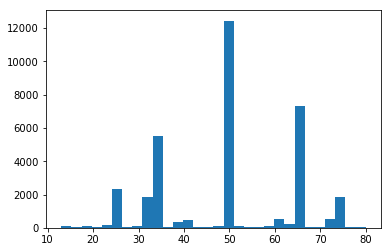

In [10]:
from matplotlib import pyplot as plt
poems_lens = [len(chars) for chars in poems_vecs]
plt.hist(poems_lens, bins=30)
plt.show()

In [11]:
print('Min length:', np.amin(poems_lens))
print('Max length:', np.amax(poems_lens))
print('Average length:', np.mean(poems_lens))
print('Median length:', np.median(poems_lens))

Min length: 13
Max length: 80
Average length: 49.4196615217
Median length: 50.0


In [12]:
np.percentile(poems_lens, [0, 25, 50, 75, 95])

array([ 13.,  34.,  50.,  65.,  74.])

**It seems more than 95% peoms has a length less than 167 characters.**

In [13]:
char2id(' ')

3690

## Input Data Generation

In [29]:
class generateSamples:
    '''Generate samples for training'''
    
    def __init__(self, batch_size, poems_vecs):
        '''Pass batch size and poems vectors'''
        self.poem_index = 0
        self.char_index = 0
        self.batch_size = batch_size
        self.poems_vecs = poems_vecs
        self.poem_count = len(poems_vecs)
        self.max_len = max(map(len, poems_vecs))
        self.chars = self._get_chars()
        
    def generate_batch(self, same_length=False):
        '''Generate a training sample containing a complete 
        poem each time'''
        start = self.poem_index
        end = start + self.batch_size
        #In case end goes beyong the range of the samples
        if end > self.poem_count:
            self.poem_index = 0
            start = 0
            end = self.batch_size
        data = self.poems_vecs[start: end]
        #Set the max lengths as the size of the input
        if same_length:
            max_len = self.max_len
        else:
            max_len = max(map(len, data))
        #Record lengths for each poem
        lengths = [len(item) for item in data]
        lengths = np.array(lengths)
        self.poem_index = (self.poem_index + self.batch_size)%self.poem_count
        #Create input and label
        x = np.full((self.batch_size,max_len), char2id(' '), np.int32)
        y = np.copy(x)
        for i in range(self.batch_size):
            #the first n elements as input
            x[i, :(len(data[i])-1)] = data[i][:-1]
            #the last n elements as labels
            y[i, :(len(data[i])-1)] = data[i][1:]
        return x, y, lengths, max_len
    
    def _get_chars(self):
        peoms_vecs_flatten = []
        for items in self.poems_vecs:
            peoms_vecs_flatten.extend(items)
        data_len = len(peoms_vecs_flatten)
        batch_len = data_len // self.batch_size
        data = np.reshape(peoms_vecs_flatten[0: self.batch_size * batch_len],
                              [self.batch_size, batch_len])
        return data
    
    def generate_batch_same_size(self, num_steps):
        '''
        Generate a batch size of characters within all the poems.
        Put all the poems into a long sentence.
        '''
        data = self.chars
        data_len = len(data)
        start = self.char_index
        end = self.char_index + num_steps
        if end > (data_len-1):
            self.char_index = 0
            start = 0
            end = num_steps
        self.char_index += num_steps
        x = data[:, start:end]
        y = data[:, (start+1):(end+1)]
        return x, y
    

In [30]:
#Generate series of inputs and labels
#Batch_size * lengths
generatesamples = generateSamples(64, poems_vecs)
x, y, lengths, _ = generatesamples.generate_batch()

In [31]:
max_poem_len = generatesamples.max_len
max_poem_len

80

## RNN Model

In [46]:
class config:
    vocab_size = len(vocab)
    embed_size = 128
    batch_size = 64
    layer_size = 2
    max_poem_len = max_poem_len

In [47]:
chunk_num = int(len(poems_vecs)/config.batch_size)
chunk_num

545

In [181]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('placeholder'):
        input_data = tf.placeholder(tf.int32, [config.batch_size, None])
        output_targets = tf.placeholder(tf.int32, [config.batch_size, None])
        lens = tf.placeholder(tf.int32, [config.batch_size])
        #keep_prob_input = tf.placeholder(tf.float32)
        #keep_prob_cell = tf.placeholder(tf.float32)
    with tf.name_scope('Embedding'):
        #Create embeddings for the characters
        embeddings = tf.Variable(tf.random_uniform([config.vocab_size, 
                                                    config.embed_size], -1.0, 1.0))
        inputs = tf.nn.embedding_lookup(embeddings, input_data)
        #Dropout
        #inputs = tf.nn.dropout(inputs, keep_prob=0.7)

    with tf.name_scope('RNNLayer') as scope:
        #gru_cell = rnn.GRUCell(config.embed_size）
        def lstm():
            return rnn.BasicLSTMCell(config.embed_size, forget_bias=0.0, 
                                      state_is_tuple=True, reuse=tf.get_variable_scope().reuse) 
        lstm_cell = lstm
        cell = rnn.MultiRNNCell([lstm_cell() for _ in range(config.layer_size)], 
                                state_is_tuple=True)
        initial_state = cell.zero_state(config.batch_size, tf.float32)
        #Dropout
        #cell = rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.7)
        weights = tf.Variable(tf.random_normal([config.embed_size, config.vocab_size]), name='weight')
        biases = tf.Variable(tf.random_normal([config.vocab_size]), name='bias')
        #outputs, status = rnn.static_rnn(lstm, inputs, sequence_length=lens)
        #Dynamic RNN with given lengths for each poem
        #status = initial_state
        outputs, status = tf.nn.dynamic_rnn(cell, inputs, initial_state=initial_state,sequence_length=lens,
                                             dtype=tf.float32, scope='RNNLayer')
        output = tf.reshape(outputs,[-1, config.embed_size])
        logits = tf.matmul(output, weights) + biases
        #logits = tf.contrib.layers.fully_connected(output, config.vocab_size, activation_fn=None)
        probs = tf.nn.softmax(logits)
        

    with tf.name_scope('Optimizer'):
        targets = tf.reshape(output_targets, [-1])
        loss = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
            [logits],
            [targets],
            [tf.ones_like(targets, dtype=tf.float32)], config.vocab_size)
        cost = tf.reduce_mean(loss) 
        learning_rate = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), 5)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.apply_gradients(zip(grads, tvars))

    
    with tf.name_scope('Validation'):
        tf.get_variable_scope().reuse_variables()
        #Define initial state for validation set
        initial_sample_state = cell.zero_state(1, tf.float32)
        sample_input = tf.placeholder(tf.int32, shape=[1, 1])
        sample_emd = tf.nn.embedding_lookup(embeddings, sample_input)
        state_sample = initial_sample_state
        output_sample, status_sample = tf.nn.dynamic_rnn(cell, sample_emd, initial_state=state_sample,
                                             dtype=tf.float32, scope='RNNLayer')
        output_sample = tf.reshape(output_sample,[-1, config.embed_size])
        logits_sample = tf.matmul(output_sample, weights) + biases
        #logits_sample = tf.contrib.layers.fully_connected(output_sample, config.vocab_size, activation_fn=None)
        probs_sample= tf.nn.softmax(logits_sample)
        prediction = tf.argmax(probs_sample, 1)

In [182]:
epochs = 1
states = []
with tf.Session(graph=graph) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for l in range(epochs):
        for i in range(chunk_num):
            sess.run(tf.assign(learning_rate, 0.002*((0.98)**l)))
            x, y, lengths, _ = generatesamples.generate_batch()
            feed_dict = {input_data:x, output_targets:y, lens:lengths}
            l, _, _ = sess.run([cost, status, train_op], feed_dict=feed_dict)
            if i%50 == 0:
                print('Loss:', round(l, 4))
            if i % 100 == 0:
                print('=' * 80)
                feed = np.zeros([1, 1])
                feed[0, 0] = char2id('(')
                s = id2char(feed[0][0])
                #Initialize the original state
                state_ = sess.run(initial_sample_state)
                [pred_id, state_] = sess.run([prediction, status_sample], feed_dict={sample_input: feed, 
                                                                          state_sample: state_})
            #pred_id = sess.run([prediction], {sample_input:feed})
            #s = id2char(pred_id[0][0])
            #生成10个单词
                for _ in range(40):
                    s += id2char(pred_id[0])
                    feed[0, 0] = pred_id[0]
                    [pred_id, state_] = sess.run([prediction, status_sample], feed_dict={sample_input: feed, 
                                                                       state_sample: state_})
                print(s)
                print('='*80)

Loss: 8.9042
(毕毕相相妻溅溅溅怅相相妻溅溅溅溅怅相相妻溅溅溅溅怅相相妻溅溅溅溅怅相相妻溅溅溅溅
Loss: 6.8254
Loss: 5.9365
(今日日不不何，不不人不人人。)      ，不不不不人人。)      ，不不不
Loss: 5.8052
Loss: 5.7192
(山山，不见人。)                                
Loss: 5.7306
Loss: 5.6365
(日日人不知，风月山山人。)人不知见，不知见山。)人不知，不知见山。)人不知，不知
Loss: 5.5926
Loss: 6.0964
(不知人知，不知不知人。)                            
Loss: 5.9374
Loss: 5.8795
(白云风水中山，花花落日人间。)       ，不知人有人间。)       ，不


## RNN Model Object

In [36]:
import functools

def lazy_property(function):
    attribute = '_cache_' + function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return decorator

In [49]:
class config:
    vocab_size = len(vocab)
    embed_size = 128
    batch_size = 64
    layer_size = 2
    num_steps = 30
    max_poem_len = max_poem_len

In [50]:
class testConfig:
    vocab_size = len(vocab)
    embed_size = 128
    batch_size = 1
    num_steps = 1
    layer_size = 2
    max_poem_len = max_poem_len

Note, in order to share parameters such as weights and biases in the architecture, it is necessary to specify "variable_scope" and use "tf.get_variable" method to share.

## Static RNN

In this part, we will take all the peoms as a long text, and use previous character to predict next character.

In [42]:
#Define a RNN model 
class static_rnnModel:
    '''Define a basic model for character classification, the model
    Provides graph structure of tensorflow'''
    
    def __init__(self, x, y,  config, is_training=True):
        self.x = x
        self.y = y
        self._num_steps = config.num_steps
        self.is_training = is_training
        self.batch_size = config.batch_size
        self.vocab_size = config.vocab_size
        self.embed_size = config.embed_size
        self.learning_rate = None
        self._initial_state = None
        self._final_state = None
        self.prediction
        if not is_training:
            print('Initializing Testing Model!')
            return
        self.cost
        self.optimize
        print('Initializing Training Model!') 
    
    @lazy_property
    def cost(self):
        #Calculatethe cost
        logits= self.rnnLayer
        #print(logits.shape)
        targets = tf.reshape(self.y, [-1])
        loss = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
            [logits],
            [targets],
            [tf.ones_like(targets, dtype=tf.float32)])
        cost = tf.reduce_mean(loss) 
        return cost

    @lazy_property
    def optimize(self):
        cost = self.cost
        #with tf.name_scope('Optimizer'):
        self.learning_rate = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), 5)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train_op = optimizer.apply_gradients(zip(grads, tvars))
        return train_op

    @lazy_property
    def prediction(self):
        logits= self.rnnLayer
        #print(logits.shape)
        probs = tf.nn.softmax(logits)
        prediction = tf.argmax(probs, 1)
        return prediction
    
    @lazy_property
    def rnnLayer(self):
        #Create two layers rnn
        def lstm():
            return rnn.BasicLSTMCell(self.embed_size, forget_bias=0.0, 
                                      state_is_tuple=True, reuse=tf.get_variable_scope().reuse) 
        lstm_cell = lstm
        #if self.is_training:
           #def lstm_cell():
                #return tf.contrib.rnn.DropoutWrapper(lstm(), output_keep_prob=0.8)
        cell = rnn.MultiRNNCell([lstm_cell() for _ in range(2)], state_is_tuple=True)
            
        self._initial_state = cell.zero_state(self.batch_size, tf.float32)
        #Note we need get_variable method to share weights between training model and testing model
        with tf.device("/cpu:0"):
            embeddings = tf.get_variable('embedding2', [self.vocab_size,  self.embed_size])
            inputs = tf.nn.embedding_lookup(embeddings, self.x)
            
        state = self._initial_state
            
        #inputs = tf.unstack(inputs, axis=1)
        outputs = []
        #Share the weights by specifyig variable scope
        with tf.variable_scope('staticRNN'):      
            for time_step in range(self._num_steps):
                if time_step > 0: tf.get_variable_scope().reuse_variables()
                (cell_output, state) = cell(inputs[:, time_step, :], state)
                outputs.append(cell_output)
        
        self._final_state = state
        output = tf.reshape(outputs,[-1, self.embed_size])
        weights = tf.get_variable('weights', [self.embed_size, config.vocab_size], dtype=tf.float32)
        biases = tf.get_variable('biases', [config.vocab_size], dtype=tf.float32)
        logits = tf.matmul(output, weights) + biases
        return logits
    
    def assign_lr(self, session, len_value):
        session.run(self._update, feed_dict={self._new_len: len_value})
    
    @property
    def learningRate(self):
        return self.learning_rate
    
    def set_maxLen(self, max_len):
        self._max_len = max_len
    
    @property
    def initialState(self):
        return self._initial_state
    
    @property
    def finalState(self):
        return self._final_state

In [43]:
graph2 = tf.Graph()

with graph2.as_default():
    initializer = tf.random_uniform_initializer(-0.05, 0.05)
    with tf.name_scope('Train'):
        input_data = tf.placeholder(tf.int32, [config.batch_size, None])
        output_targets = tf.placeholder(tf.int32, [config.batch_size, None])
        with tf.variable_scope("staticModel", reuse=None, initializer=initializer):
            train_model = static_rnnModel(input_data, output_targets, config)
            
    with tf.name_scope('Test'):
        sample_input = tf.placeholder(tf.int32,[1, 1])
        with tf.variable_scope("staticModel", reuse=True, initializer=initializer):
            test_model = static_rnnModel(sample_input, None, 
                                         testConfig, False)

Initializing Training Model!
Initializing Testing Model!


In [53]:
epochs = 10
states = []
with tf.Session(graph=graph2) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    #record initial state
    for l in range(epochs):
        sess.run(tf.assign(train_model.learningRate, 0.002*(0.97**l)))
        for i in range(chunk_num):
            #Assign a learning rate
            #sess.run(tf.assign(model.isTraining, True))
            x, y = generatesamples.generate_batch_same_size(config.num_steps)
            feed_dict = {input_data:x, output_targets:y}
            #train_model.set_maxLen(max_len)
            l,  _ = sess.run([train_model.cost, train_model.optimize], feed_dict)
            if i%50 == 0:
                print('Loss:', round(l, 4))
            if i%100 == 0:
                #Initialize testing input
                feed = np.zeros([1, 1])
                feed[0, 0] = char2id('(')
                s = '('
                #Specify initial state
                #Initialize the state of testing data
                initial_state = sess.run(test_model.initialState)
                state = initial_state

                #生成10个单词
                for _ in range(30):
                    fd= {sample_input:feed, test_model.initialState:state}
                    state, pred_id = sess.run([test_model.finalState, 
                                                     test_model.prediction], feed_dict=fd)
                    #feed = np.full((1,testConfig.max_poem_len), char2id(' '), np.int32)
                    feed[0, 0] = pred_id[0]
                    s += id2char(feed[0, 0])
                print(s)
                print('='*80)

Loss: 8.22
(年年年年年公年年年公年年年公年年年公年年年公年年年公年年年公
Loss: 6.1621
Loss: 6.1318
(，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
Loss: 6.127
Loss: 6.12
(，，，，，，，，，，，。。。。。。。。。。。。。。。。。。。
Loss: 6.0959
Loss: 6.0506
(，，，，，，，，，，，，，，，，，，。。。。。。。。。。。。
Loss: 5.991
Loss: 5.9607
()，，，。。。。。。。。。。。。。。。。。。。。。。。。。。
Loss: 5.8693
Loss: 5.8028
(万，，，，，。。。。。。。。。。。。。。。。。。。。。。。。
Loss: 5.6988
(万，，，，，。。。。。。。。。。。。。，，，，，，，，，，，
Loss: 5.5988
Loss: 5.4299
(万。。。，，，。。。。。。。。。。。。。。。。。。。。。，，
Loss: 5.2344
Loss: 5.0437
(万。。。。。。。。。。。。。。。。。。。。。。。。。。。。。
Loss: 4.8609
Loss: 4.6884
(万。。君。。。。。。。。。。。。。。。。。。。。。。。。。。
Loss: 4.5264
Loss: 4.3674
(万。君君君。。。。。。。。。。。。。。。。。。。。。。。。。
Loss: 4.2115
Loss: 4.0547
(万。君君君君。((。。。。((。。。。。。。。。。。。。。。
Loss: 4.2219
(万。君君君君。((((((((((((。。。。。。。。。。。
Loss: 4.0747
Loss: 3.9313
(万光君君君君。(((((((((((((((((((((((
Loss: 3.7739
Loss: 3.6179
(万光君君君君君(((((((((((((((((((((((
Loss: 3.4698
Loss: 3.2868
(万光君君君君。((((((((((((((。。，，，，，，，
Loss: 3.1141
Loss: 2.9504
(万光君君君君((末。。((((，，，，，。。。。。。。。。。
Loss: 2.781
Loss: 2.6208
(万光君君君((云末，恐深 ，，杂，，，，，，，，，，，，，，
Lo

KeyboardInterrupt: 